# Surprisal and Entropy of Function and Content Words
Kaitlyn Chou, LIGN 169 Winter 2025

## Introduction

All English words can be categorized into two main groups. Function words have grammatical functions and are a closed class, meaning there is a limited and mostly unchanging set of them that are used by speakers. Generally, function words are defined as determiners (e.g. *the*, *a*, *this*), quantifiers (*some*, *much*), prepositions (*of*, *through*), conjunctions (*and*, *but*, *because*), auxiliary verbs (*be*, *do*, *have*), modal verbs (*could*, *must*), and pronouns (*he*, *their*).<sup><a href="#footnote1">[1]</a></sup> Content words are all words that aren’t function words, and they refer to some thing, concept, or idea in the world. Thus, they include all nouns, verbs, adjectives, and adverbs. Language users are always adding new content words to the dictionary and conversational vocabulary, which makes content words an open class.

Function words often occupy specific positions in sentences in order to form grammatical sentences. For example, articles always come before nouns and conjunctions always link together two clauses or phrases. Since function words are more frequent in language and they are used in very specific structures, it seems to follow that they are also more predictable. In information theory, the surprisal, or information content, of the next word is defined by the negative log probability of the word given the context (all the words before it). The larger the surprisal value is, the more “surprised” you would be to see the word and thus the more information it gives. The entropy, or uncertainty of the next word, is essentially a weighted average of all of the surprisals. I would suspect that the surprisal of function words is lower than that of content words because the structure of a sentence’s context sets up a particular position for a function word to occupy. This may also mean lower entropy/uncertainty, because the context of a sentence often makes it clear (less uncertain) that the next word should be a function word. This project seeks to investigate this hypothesis and quantify the difference between the predictability of function and content words using an autoregressive language model, GPT-2, which predicts the next word in a stream of text. This notebook will first outline the methods of cleaning the corpus, choosing a list of words, and calculating the surprisal and entropy values of each word. Then, the analysis portion will focus on how the two groups (function/content) differ from each other as well as an exploration of distinctions by part of speech.


## Methods

### Function Words

I will be investigating and comparing the surprisal and entropy of a small sample of function and content words. For my list of function words, I am using the nltk stopwords as a basis and adding more words manually based on the common function words from the corpus. This is not an exhaustive list, but it will be used to separate the function words from the most common words in the corpus. I took a subset of these words to actually use in my list of test words.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import re
import matplotlib.pyplot as plt
import nltk
import warnings
warnings.filterwarnings('ignore')

C:\Users\Kaitlyn Chou\AppData\Local\Temp\ipykernel_16348\4218350674.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [111]:
from nltk.corpus import stopwords
nltk.download('stopwords')

funcs = stopwords.words('english')
funcs = funcs + ['although', 'anything', 'anyone', "ain't", 'also', "an'", "'cause", "can't", 'cannot', "'em", 'however', "here's", 'neither', 'must', 'shall', 'since', 
                 'somebody', 'someone', 'gotta', 'could', "could've", "what's", "what're", 'would', "would've", 'whose', "who's", 'whatever', 'without', 'yes', 'yeah', 'yet', 'towards', 'oh', 
                 'ok', 'okay', "that's", 'ought', "where's", "there's", "she's", 'ooh', 'uhhuh', 'erm', 'everyone', 'either', 'much', 'might', 'something', 'huh', 'hafta', 'mhm', 'hey', 'nothing']
funcs.sort()
print(funcs)

["'cause", "'em", 'a', 'about', 'above', 'after', 'again', 'against', 'ain', "ain't", 'all', 'also', 'although', 'am', 'an', "an'", 'and', 'any', 'anyone', 'anything', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', "can't", 'cannot', 'could', "could've", 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'either', 'erm', 'everyone', 'few', 'for', 'from', 'further', 'gotta', 'had', 'hadn', "hadn't", 'hafta', 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'hey', 'him', 'himself', 'his', 'how', 'however', 'huh', 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mhm', 'might', 'mightn', "mightn't", 'more', 'most', 'much', 'must', 

[nltk_data] Downloading package stopwords to C:\Users\Kaitlyn
[nltk_data]     Chou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [98]:
function = ['about', 'above', 'after', 'against', 'although', 'any', 'because', 'before', 'below', 'between', 'cannot', 'could', 'doing', 'during', 'either', 'further', 'here', 'hers', 'how', 'if', 'into', 'just', 'must', 'my', 'neither', 'only', 'ought', 'shall', 'should', 'since', 'some', 'than', 'their', 'there', 'these', 'they', 'those', 'through', 'too', 'towards', 'under', 'until', 'when', 'while', 'whom', 'whose', 'why', 'would', 'yet']

### Content Words

For the content words, I will be randomly sampling from the BabyLM corpus.<sup><a href="#footnote2">[2]</a></sup> The training corpus consists of six sources which include transcripted dialogue, Simple English Wikipedia, and fiction text. The preprocessing of the corpus consisted of removing special characters (only apostrophes are kept), lowering case, stripping extra whitespace, and splitting by paragraph. The surprisal of any first word in a sequence is 0 by convention since there is no prior context,<sup><a href="#footnote3">[3]</a></sup> so I then removed all sequences in the corpus with only one word, as they wouldn’t add anything to the entropy of the word.

In [3]:
# read in text files
wiki = open("simple_wiki.train", encoding='utf-8').read()
guten = open("gutenberg.train", encoding='utf-8').read()
guten = re.sub("’", "'", guten, flags=re.MULTILINE)
bnc = open("bnc_spoken.train", encoding='utf-8').read()
child = open("childes.train", encoding='utf-8').read()
child = re.sub(r'\*CHI:|\*MOT:|\*COL:|\*RIC:|\*FAT:|\*URS:|\t', "", child, flags=re.MULTILINE)
switch = open("switchboard.train", encoding='utf-8').read()
switch = re.sub(r'A:|B:|\t', "", switch, flags=re.MULTILINE)
sub = open("open_subtitles.train", encoding='utf-8').read()

corpus = []
# clean text
for text in [wiki, guten, bnc, child, switch, sub]:
    text_split = re.split(r'\n', text, flags=re.MULTILINE)
    text_split = [re.sub(r"[^a-zA-Z\d\s']", "", x) for x in text_split]
    text_split = [x.strip().lower() for x in text_split]
    corpus = corpus + text_split
corpus = [s for s in corpus if s != ""]

In [4]:
# delete all sentences with only one word or too many tokens for the token_score function
corpus_tokenized = [sequence.split() for sequence in corpus]
corpus_tokenized = [s for s in corpus_tokenized if (s != []) and (1<len(s)<512)]
for sequence in corpus_tokenized: 
    sequence = [x.strip() for x in sequence]
corpus = [' '.join(sequence) for sequence in corpus_tokenized]

To obtain my list of content words, I counted all the words in the corpus and randomly sampled 60 common words (500th-1000th most frequent) and 15 relatively uncommon words (3000th-3500th most frequent). I limited these to exclude the list of function words, and to be real words as conditioned by the nltk words corpus.

In [6]:
# count common and relatively uncommon words
from collections import Counter

counter = Counter()
for sentence in corpus_tokenized:
    counter.update(sentence)

common = [word[0] for word in counter.most_common()[500:1000]]
uncommon = [word[0] for word in counter.most_common()[3000:3500]]

In [7]:
from nltk.corpus import words
nltk.download('words')

# randomly sample common and relatively uncommon words
common_filtered = [word for word in common if (word not in funcs) and (len(word) > 2) and (word in set(words.words()))]
uncommon_filtered = [word for word in uncommon if (word not in funcs) and (len(word) > 2) and (word in set(words.words()))]

random.seed(25)
common_content = random.sample(common_filtered, 60)
uncommon_content = random.sample(uncommon_filtered, 15)
content = common_content + uncommon_content
print(content)

[nltk_data] Downloading package words to C:\Users\Kaitlyn
[nltk_data]     Chou\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


['area', 'week', 'ride', 'lunch', 'strong', 'spoon', 'knew', 'couple', 'anyway', 'cry', 'free', 'small', 'star', 'full', 'circle', 'peter', 'running', 'hurry', 'leaves', 'straight', 'truck', 'background', 'wow', 'bunny', 'holding', 'drop', 'moment', 'giving', 'turns', 'works', 'station', 'perhaps', 'born', 'wash', 'coffee', 'apple', 'favorite', 'animal', 'bus', 'city', 'alone', 'glad', 'cried', 'eight', 'true', 'line', 'wet', 'letter', 'nose', 'lie', 'wear', 'state', 'blow', 'company', 'busy', 'sun', 'lion', 'blood', 'mike', 'married', 'split', 'location', 'han', 'lick', 'messy', 'hopefully', 'pray', 'splash', 'drug', 'tasty', 'cutie', 'shadow', 'burned', 'kingdom', 'fashion']


In [9]:
test_words = set(content + function)

The last step in preparing for the calculations of surprisals and entropy was to filter the corpus to only include sentences which contain the words of interest, so that we don't spend computing power on sentences that do not contain any of these words.

In [11]:
corpus_filtered_tokenized = [s for s in corpus_tokenized if any(word in test_words for word in s)]
corpus_filtered = [' '.join(s) for s in corpus_filtered_tokenized]

### Calculate Surprisals

To calculate the surprisal and entropy of my list of words, I am using the minicons library, which has a token_score() function that takes a sentence and returns the surprisal of each token given all of the context before it. In the following code, for each sequence in the filtered corpus, token_score calculates $I(w_i) = -\log_2(P(w_i  | w_1, w_2, ... w_{i-1}))$ for every $w_i$ in the sequence and saves this surprisal value for each instance of each test word. This was the most time consuming step since several thousand sentences had to be fed into the function. After this was completed, I saved the words, their corresponding lists of surprisals, and their word type in a pandas DataFrame for further analysis.

In [13]:
from minicons import scorer
import torch
from torch.utils.data import DataLoader
import json

In [14]:
model = scorer.IncrementalLMScorer('gpt2', 'cpu')
surprisals = {word: [] for word in test_words} 
for i in range(len(corpus_filtered)):
    all_surprisals = model.token_score(corpus_filtered[i], surprisal = True, base_two = True)
    for token in all_surprisals[0]:
        if token[0] in test_words:
            surprisals[token[0]].append(token[1])

In [63]:
# create dataframe to organize list of words, surprisals, and word type
df = pd.DataFrame(list(surprisals.items()), columns=['Word', 'Surprisals'])
df['Type'] = df['Word'].apply(lambda x: 'Function' if x in function else 'Content')

### Calculate Entropies

Next I calculated the entropy for each word which is calculated by summing each surprisal value multiplied by the probability of that word. Since the function directly computed surprisal without providing probabilities first, probability is expressed as $2^{-I(w_i)}$.

In [64]:
def get_entropy(surprisals):
    return sum((2**(-x))*x for x in surprisals)
df['Entropy'] = df['Surprisals'].apply(get_entropy)

## Analysis & Results

### Mean Surprisals

The mean surprisal for each word is obtained by averaging all of the surprisal values of each instance of the word in the corpus. The 10 words with lowest and highest mean surprisal are listed below. Notably, all of the words with lowest mean surprisal are function words, and nearly all the words with highest mean surprisal are content words. This does appear to suggest that function words have lower surprisal values overall.

In [83]:
df['Mean Surprisal'] = df['Surprisals'].apply(lambda x: sum(x) / len(x) if x else None)
df[['Word', 'Type', 'Mean Surprisal']].sort_values(by='Mean Surprisal').head(10)

,Word,Type,Mean Surprisal
21,than,Function,2.740686
34,why,Function,3.871773
29,how,Function,3.964358
60,shall,Function,4.695943
81,about,Function,4.751260
17,if,Function,4.901727
62,because,Function,4.947022
99,they,Function,4.996709
57,although,Function,5.214869
104,doing,Function,5.220090


In [99]:
df[['Word', 'Type', 'Mean Surprisal']].sort_values(by='Mean Surprisal').tail(10)

,Word,Type,Mean Surprisal
59,tasty,Content,14.283998
105,pray,Content,14.372381
9,spoon,Content,14.375836
122,hopefully,Content,14.432848
117,lion,Content,14.621517
56,lick,Content,14.767992
15,bunny,Content,15.093943
63,neither,Function,15.190907
100,splash,Content,15.591504
75,cried,Content,16.150021


After averaging the mean surprisal value for all function words and all content words, it can be seen that function words indeed tend to have lower surprisals than content words. Function words have an average surprisal of 7.04 bits while content words have an average surprisal of 10.41 bits.

In [45]:
function_avg = df[df['Type']=='Function']['Mean Surprisal'].mean()
content_avg= df[df['Type']=='Content']['Mean Surprisal'].mean()
print("Average of mean surprisal for function words: " + f"{function_avg:.2f}" + " bits")
print("Average of mean surprisal for content words: " + f"{content_avg:.2f}" + " bits")

Average of mean surprisal for function words: 7.04 bits
Average of mean surprisal for content words: 10.41 bits


The following visualizations show the spread of mean surprisals for content and function words. In the histogram, the means of each group are shown as dotted lines. A large number of function words have mean surprisals that lie between 6 and 7 bits, while many content words have surprisals that lie between 9 and 10 bits. The function words have a slightly right-skewed distribution while the content words have a more normal distribution.

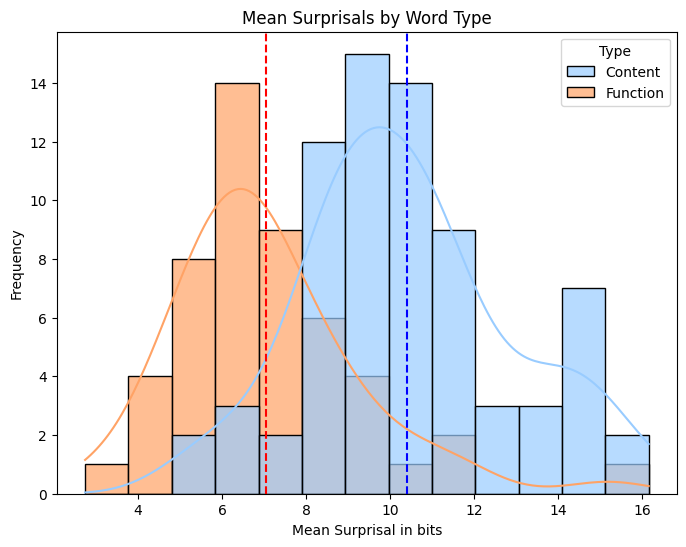

In [46]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Mean Surprisal', hue='Type', kde=True, binwidth=1, alpha=0.7, palette={'Function': '#ffa366', 'Content': '#99ccff'})
plt.axvline(function_avg, color='red', linestyle='--')
plt.axvline(content_avg, color='blue', linestyle='--')
plt.xlabel('Mean Surprisal in bits')
plt.ylabel('Frequency')
plt.title('Mean Surprisals by Word Type')
plt.show()

The boxplot below shows another representation of the differences in mean surprisals by word type. The medians between the two groups show a similar difference as the means, and the 1st and 3rd quartiles give a sense of how far apart the middle 50% of each group is. 

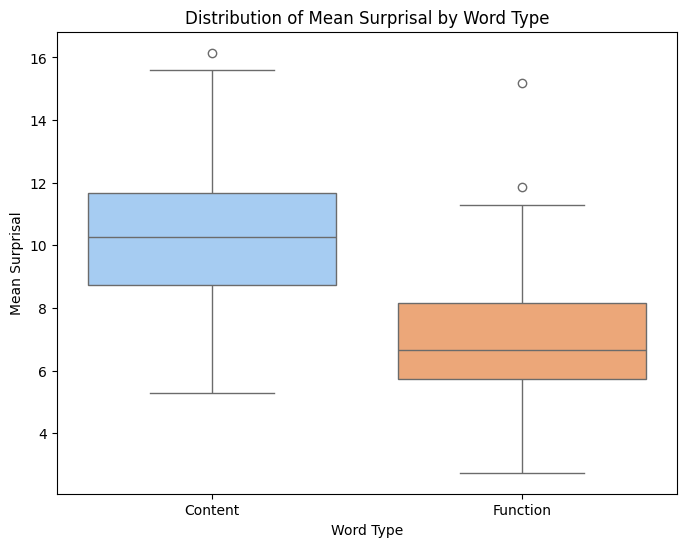

In [36]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Type', y='Mean Surprisal', palette={'Function': '#ffa366', 'Content': '#99ccff'})
plt.title('Distribution of Mean Surprisal by Word Type')
plt.xlabel('Word Type')
plt.ylabel('Mean Surprisal')
plt.show()

### Entropy

Contrary to the pattern with mean surprisals, the words with highest entropy are function words while the words with lowest entropy are mostly content words. However, the words with high entropies have very unusually high entropies; this might be because these words occur so frequently in so many contexts with an even probability distribution which leads to high uncertainty, and also because the corpus does not sample all contexts in which the words appear. Likewise, words like "lick," "burned," and "messy" might have lower entropies because they occur in more specific, predictable contexts.

In [101]:
df[['Word', 'Type', 'Entropy']].sort_values(by='Entropy').tail(10)

,Word,Type,Entropy
119,some,Function,461.944692
21,than,Function,467.731840
46,just,Function,489.493581
17,if,Function,584.053884
104,doing,Function,777.592795
24,here,Function,882.460906
99,they,Function,1003.364241
85,there,Function,1032.433999
84,my,Function,1294.895258
81,about,Function,1324.724033


In [100]:
df[['Word', 'Type', 'Entropy']].sort_values(by='Entropy').head(10)

,Word,Type,Entropy
57,although,Function,0.034166
63,neither,Function,0.057603
122,hopefully,Content,0.064995
100,splash,Content,0.147553
56,lick,Content,0.169955
120,shadow,Content,0.234517
12,burned,Content,0.320368
105,pray,Content,0.327518
36,perhaps,Content,0.345333
70,messy,Content,0.357500


The histogram shows that function words have an extremely wide and varied distribution of entropy while the content words are all clustered at the low entropy end. This is a very different pattern than what was seen in the mean surprisals plot.

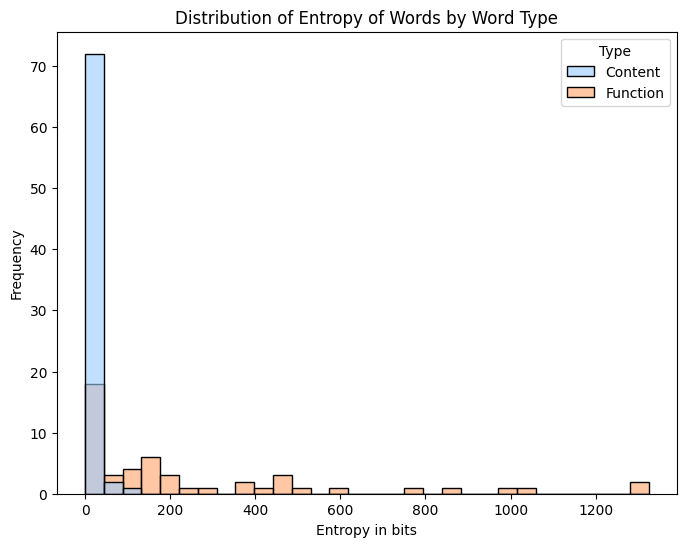

In [49]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Entropy', hue='Type', bins=30, alpha=0.6, palette={'Function': '#ffa366', 'Content': '#99ccff'})
plt.xlabel('Entropy in bits')
plt.ylabel('Frequency')
plt.title('Distribution of Entropy of Words by Word Type')
plt.show()

### Grouping by Part of Speech

I was also interested in differences in surprisal/entropy at a more granular level of distinction than function vs. content words. I added part of speech (POS) as a column to the table, using nltk's part of speech tagging function. Their distinctions are more granular than I need, so I grouped together some labels (with the help of [this guide](https://www.learntek.org/blog/categorizing-pos-tagging-nltk-python/)) and recoded them to be more informative.

In [75]:
from nltk.tag import pos_tag
df['POS'] = df['Word'].apply(lambda x: nltk.pos_tag([x])[0][1])
df[['Word', 'Type', 'POS']].head(10)

,Word,Type,POS
0,free,Content,JJ
1,between,Function,IN
2,below,Function,IN
3,cannot,Function,NN
4,background,Content,NN
5,since,Function,IN
6,these,Function,DT
7,married,Content,JJ
8,sun,Content,NN
9,spoon,Content,NN


Since these words were tagged without context, words that can have multiple parts of speech (e.g. "leaves" as the plural of "leaf" or as the third person singular present tense form of "leave") may have been tagged arbitrarily. There were also some words that were just tagged incorrectly, which I manually fixed. 

In [76]:
# manually adjusting wrong tags
df.loc[df['Word'] == 'cannot', 'POS'] = 'MD'
df.loc[df['Word'] == 'hers', 'POS'] = 'PRP$'
df.loc[df['Word'] == 'wet', 'POS'] = 'JJ'
df.loc[df['Word'] == 'glad', 'POS'] = 'JJ'
df.loc[df['Word'] == 'towards', 'POS'] = 'IN'

In [77]:
df['POS'].unique()

array(['JJ', 'IN', 'MD', 'NN', 'DT', 'CD', 'VBN', 'RB', 'NNS', 'WP$',
       'WRB', 'PRP$', 'VBG', 'WP', 'PRP'], dtype=object)

In [79]:
# recode labels for part of speech 
df['POS'] = df['POS'].replace({'NN': 'Noun', 'IN': 'Preposition', 'NNS': 'Noun', 'RB': 'Adverb', 'DT': 'Determiner', 'WRB': 'Pronoun', 'PRP$': 'Pronoun', 'PRP': 'Pronoun', 'MD': 'Modal', 'VBD': 'Verb', 'VBG': 'Verb', 'CD': 'Determiner', 'WP$': 'Pronoun', 'JJ': 'Adjective', 'WP': 'Pronoun', 'VBN': 'Verb'})
df['POS'].unique()

array(['Adjective', 'Preposition', 'Modal', 'Noun', 'Determiner', 'Verb',
       'Adverb', 'Pronoun'], dtype=object)

The following boxplot shows similar results to the function word/content word distinction. Determiners, modals, prepositions, and pronouns have lower mean surprisals while while nouns, verbs, adjectives, and adverbs have higher mean surprisals. The exact average values are also calculated below.

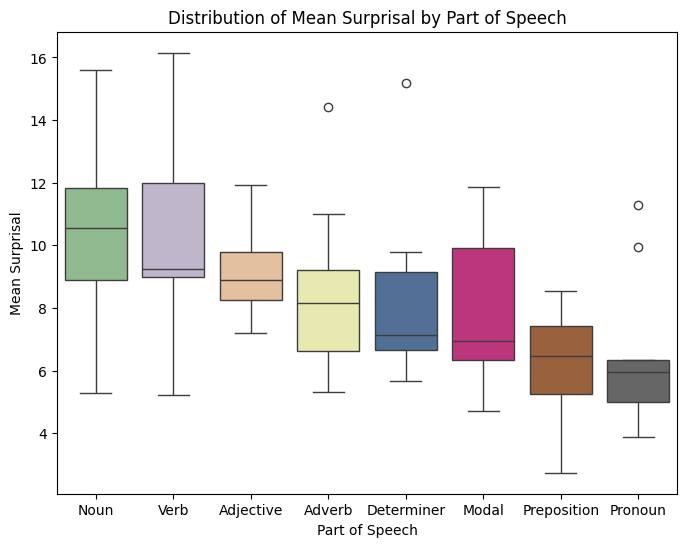

In [105]:
plt.figure(figsize=(8, 6))
palette={'Adjective':'#EEC095', 'Preposition':'#AA5F2C', 'Modal':'#D2207E', 'Noun':'#88C088', 'Determiner':'#476EA1', 'Verb':'#BFB3CF', 'Adverb':'#F2F2A6', 'Pronoun':'#666666'}
sns.boxplot(data=df, x='POS', y='Mean Surprisal', order=df.groupby('POS')['Mean Surprisal'].median().sort_values(ascending=False).index, palette=palette)
plt.title('Distribution of Mean Surprisal by Part of Speech')
plt.xlabel('Part of Speech')
plt.ylabel('Mean Surprisal')
plt.show()

In [97]:
# average mean of means by part of speech
print("Average of mean surprisals by part of speech")
print("Nouns: " + f"{df[df['POS']=='Noun']['Mean Surprisal'].mean():.2f}" + " bits")
print("Pronouns: " + f"{df[df['POS']=='Pronoun']['Mean Surprisal'].mean():.2f}" + " bits")
print("Verbs: " + f"{df[df['POS']=='Verb']['Mean Surprisal'].mean():.2f}" + " bits")
print("Prespositions: " + f"{df[df['POS']=='Preposition']['Mean Surprisal'].mean():.2f}" + " bits")
print("Adverbs: " + f"{df[df['POS']=='Adverb']['Mean Surprisal'].mean():.2f}" + " bits")
print("Determiners: " + f"{df[df['POS']=='Determiner']['Mean Surprisal'].mean():.2f}" + " bits")
print("Modals: " + f"{df[df['POS']=='Modal']['Mean Surprisal'].mean():.2f}" + " bits")

Average of mean surprisals by part of speech
Nouns: 10.59 bits
Pronouns: 6.49 bits
Verbs: 10.29 bits
Prespositions: 6.40 bits
Adverbs: 8.42 bits
Determiners: 8.58 bits
Modals: 8.00 bits


When comparing the entropy of words by part of speech, pronouns, determiners, adverbs, prepositions and modals have higher median entropies while adjectives, verbs, and nouns have lower median entropies. This is sort of the reverse pattern as the pattern for mean surprisals and this is also mostly consistent with function words having lower surprisals but higher entropies. What's notable here is that adverbs have similar entropies to other function words even though they're typically categorized as content words. I think this is because some adverbs, especially those not modifying physical actions, have more grammatical than semantic roles in sentences, like *just* and *extremely*. 

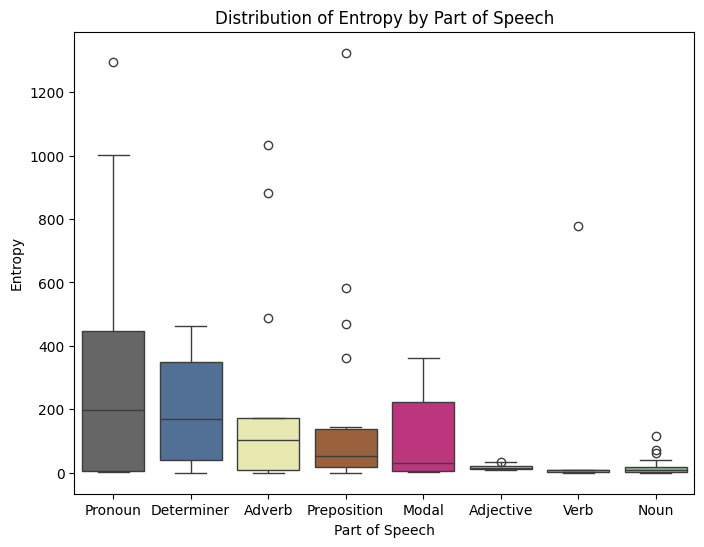

In [107]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='POS', y='Entropy', order=df.groupby('POS')['Entropy'].median().sort_values(ascending=False).index, palette=palette)
plt.title('Distribution of Entropy by Part of Speech')
plt.xlabel('Part of Speech')
plt.ylabel('Entropy')
plt.show()

## Conclusion

Based on the results of my analysis of the BabyLM corpus using the language model GPT-2, function words generally have **lower surprisals** than content words, but **higher entropies** than content words. Specifically, pronouns have the lowest average surprisals but the highest entropies. This means that when a language model is predicting the next word in a sentence, function words are less surprising and less informative. This makes sense, because function words generally don't have much meaning tied to them. Content words are more informative and thus have higher surprisal values, but becaues there is such a large set of possible content words (a greater set than the limited number of function words), they also have high uncertainty/entropy. Notably, this was a fairly small-scale project due to computing power limitations. I would run it again on a much larger set of words and a larger corpus if possible for more reliable results.

#### Sources
1. [https://en.wikipedia.org/wiki/Function_word](https://en.wikipedia.org/wiki/Function_word)
2. [https://babylm.github.io/](https://babylm.github.io/)
3. [https://github.com/kanishkamisra/minicons/blob/master/examples/surprisals.md](https://github.com/kanishkamisra/minicons/blob/master/examples/surprisals.md)
4. [https://www.learntek.org/blog/categorizing-pos-tagging-nltk-python/](https://www.learntek.org/blog/categorizing-pos-tagging-nltk-python/)